# Engenharia de Atributos (Feature Engineering)

**Objetivo:** Preparar o dataset para modelagem preditiva.
Nesta etapa, vamos:
1.  **Limpar:** Tratar valores nulos e inconsistências.
2.  **Criar Lags (Defasagens):** A economia demora a reagir. A Selic de hoje impacta a inadimplência daqui a 6 meses. Criaremos variáveis para capturar isso.
3.  **Sazonalidade:** Criar indicadores de meses e períodos de Safra (importante para o Crédito Rural).
4.  **Salvar:** Exportar o dataset pronto (`df_modelagem.csv`) na pasta `processed`.

In [1]:
# --- 1. Configuração e Carga ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from pathlib import Path

# Configurações visuais
sns.set_theme(style="whitegrid")
base_path = Path("../data/raw/")

print("Carregando arquivos...")

# Lista de arquivos
arquivos = {
    "inad": "df_inadimplencia.csv",
    "econ": "df_economico.csv",
    "ibge": "df_ibge.csv",
    "clima": "df_inmet.csv",
    # Nota: Não carregamos eventos políticos aqui pois focaremos em variáveis numéricas para o modelo
}

dfs = []
for nome, arquivo in arquivos.items():
    caminho = base_path / arquivo
    if caminho.exists():
        df_temp = pd.read_csv(caminho)
        
        # Tratamento de Data
        if "data" in df_temp.columns:
            df_temp["data"] = pd.to_datetime(df_temp["data"])
        
        # Remover colunas auxiliares que atrapalham o merge
        if "data_str" in df_temp.columns:
            df_temp = df_temp.drop(columns=["data_str"])
            
        dfs.append(df_temp)
    else:
        print(f"Aviso: {arquivo} não encontrado.")

# Merge Unificado
df_mestre = reduce(lambda left, right: pd.merge(left, right, on="data", how="outer"), dfs)

# Alinhamento Temporal (Resample para garantir dia 01 do mês e unicidade)
df_mestre.set_index("data", inplace=True)
df_mestre = df_mestre.resample("MS").mean(numeric_only=True)

# Filtro de Data (Início da série consistente)
df_mestre = df_mestre[df_mestre.index >= "2015-01-01"]

print(f"Dataset Base Montado. Shape: {df_mestre.shape}")
display(df_mestre.head(3))

Carregando arquivos...
Dataset Base Montado. Shape: (132, 29)


,inad_pj_tot,inad_pf_tot,inad_rd_pf_cr_rur_tot,inad_rd_pj_cr_rur_tot,ipca,spread_pf,spread_pj,spread_tot,icms_petroleo,soja_triturada_expt,...,p14m_forca_trabalho_mil,p14m_ocupadas_mil,p14m_desocupadas_mil,p14m_fora_forca_trabalho_mil,tx_foca_trabalho_p14m_pct,tx_desocupacao_p14m_pct,insolacao_total_h,precipitacao_total_mm,temp_max_media_c,umidade_media_pct
data,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.98,3.75,1.36,0.66,2.50,22.39,8.70,15.68,5556575.0,3.510272e+07,...,99277.0,91312.0,7965.0,59812.0,62.4,8.0,230.26,118.75,32.58,70.55
2015-02-01,1.99,3.81,1.53,0.71,2.37,23.23,9.05,16.28,5494786.0,3.461604e+08,...,99277.0,91312.0,7965.0,59812.0,62.4,8.0,171.73,169.88,31.28,76.14
2015-03-01,2.06,3.67,1.55,0.72,3.36,22.91,8.85,16.03,5076328.0,2.211790e+09,...,99277.0,91312.0,7965.0,59812.0,62.4,8.0,180.71,188.78,30.71,78.16


## 2. Limpeza de Dados (Data Cleaning)
Antes de criar variáveis, precisamos resolver os "buracos" (Nulls).
* **Regra 1:** Se uma coluna tem mais de 30% de dados faltantes, ela é descartada (pouca confiabilidade).
* **Regra 2:** Para pequenas falhas em séries temporais econômicas, usamos **Interpolação Linear** (preenche o buraco traçando uma reta entre o ponto anterior e o próximo).

In [2]:
# Cópia de segurança
df_clean = df_mestre.copy()

# 1. Remover colunas com excesso de nulos (>30%)
limit_null = len(df_clean) * 0.30
cols_to_drop = df_clean.columns[df_clean.isnull().sum() > limit_null]

if len(cols_to_drop) > 0:
    print(f"Removendo colunas vazias/ruins: {list(cols_to_drop)}")
    df_clean = df_clean.drop(columns=cols_to_drop)

# 2. Interpolação (Preencher buracos no meio da série)
# Ex: Jan=10, Fev=NaN, Mar=12 -> Fev vira 11.
df_clean = df_clean.interpolate(method='time')

# 3. Preencher pontas (Se o primeiro mês for NaN, repete o segundo)
df_clean = df_clean.ffill().bfill()

# Check final
nulos = df_clean.isnull().sum().sum()
print(f"Total de valores nulos restantes: {nulos}")

Removendo colunas vazias/ruins: ['icms_petroleo', 'soja_triturada_expt', 'soja_residuo_expt', 'soja_oleo_expt', 'milho_grao_expt']
Total de valores nulos restantes: 0


## 3. Feature Engineering: Lags (Defasagens)
Em macroeconomia, o efeito não é imediato.
* Se a **Selic** sobe hoje, o crédito fica mais caro, mas a pessoa só para de pagar a conta daqui a 3 ou 6 meses.
* Por isso, criamos versões "atrasadas" das variáveis.

**Variáveis criadas:** Lag de 3, 6 e 12 meses.

In [3]:
df_eng = df_clean.copy()

# Variáveis que impactam a economia (Inputs)
# Não fazemos lag da Inadimplência (Target) agora, pois isso seria Data Leakage em alguns contextos,
# mas podemos usar a inadimplência passada como feature (Auto-Regressão)
vars_macro = [
    'selic', 
    'ipca', 
    'tx_desocupacao_p14m_pct', 
    'rendimento_medio_mensal_reais',
    'dolar_ptax',
    'icms_petroleo' # Se existir
]

# Períodos de atraso (Trimestre, Semestre, Ano)
lags = [3, 6, 12]

print("Gerando variáveis defasadas...")

for col in vars_macro:
    if col in df_eng.columns:
        for lag in lags:
            col_name = f"{col}_lag_{lag}"
            df_eng[col_name] = df_eng[col].shift(lag)

# Remover os meses iniciais que ficaram vazios por causa do shift
# (Ex: Se fiz lag de 12, os primeiros 12 meses viraram NaN)
df_eng = df_eng.dropna()

print(f"Shape final após Lags: {df_eng.shape}")

Gerando variáveis defasadas...
Shape final após Lags: (120, 39)


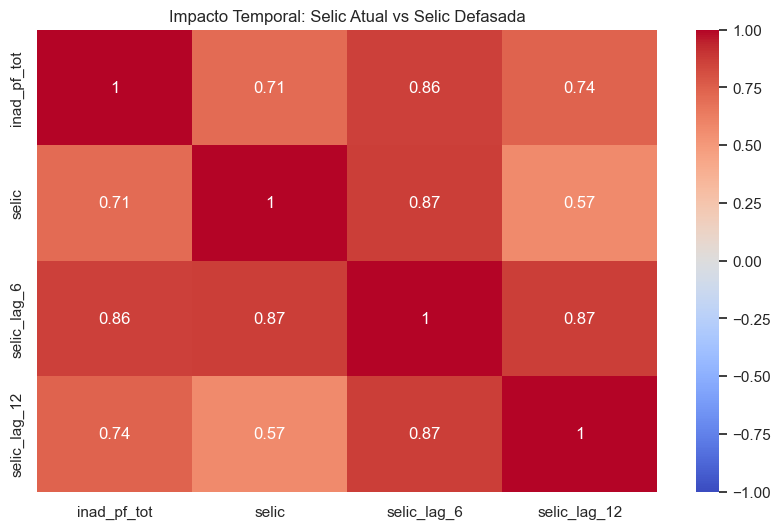

In [4]:
# Vamos provar que o Lag funciona?
# Correlação da Inadimplência com Selic Hoje vs Selic 1 ano atrás
cols_check = ['inad_pf_tot', 'selic', 'selic_lag_6', 'selic_lag_12']

plt.figure(figsize=(10, 6))
sns.heatmap(df_eng[cols_check].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Impacto Temporal: Selic Atual vs Selic Defasada")
plt.show()

## 4. Sazonalidade e Features Específicas
* **Mês:** Ajuda o modelo a entender padrões de Natal/Fim de ano.
* **Safra:** Flag binário (0 ou 1) indicando meses de colheita forte (Soja/Milho) no primeiro semestre, crucial para análise de Crédito Rural.

In [5]:
# 1. Extrair Mês Numérico (1 a 12)
df_eng['mes'] = df_eng.index.month

# 2. Trimestre
df_eng['trimestre'] = df_eng.index.quarter

# 3. Flag de Safra (Simplificado para Agro Brasileiro: Fev a Maio forte)
# 1 = Período de Safra, 0 = Entressafra
df_eng['flag_safra'] = df_eng['mes'].apply(lambda x: 1 if x in [2, 3, 4, 5] else 0)

display(df_eng[['mes', 'flag_safra']].head())

,mes,flag_safra
data,,
2016-01-01,1,0
2016-02-01,2,1
2016-03-01,3,1
2016-04-01,4,1
2016-05-01,5,1


## 5. Exportação
Salvando o arquivo consolidado para a etapa de Modelagem.

In [6]:
# Caminho de saída
path_out = Path("../data/processed/")
path_out.mkdir(parents=True, exist_ok=True) # Cria a pasta se não existir

# Salvar
df_eng.to_csv(path_out / "df_modelagem.csv")

print(f"Sucesso! Arquivo salvo em: {path_out / 'df_modelagem.csv'}")
print("Próximo passo: 04_treinamento_modelo.ipynb")

Sucesso! Arquivo salvo em: ..\data\processed\df_modelagem.csv
Próximo passo: 04_treinamento_modelo.ipynb
